### Discription
This notebook is inspired by the Boston housing price example from Deep Learning with Python by François Chollet and is implemented here for learning purposes with some additional explanations on the basis of my understanding.

# Boston housing price dataset
Goal of this experiment is to predict the median house prices in a given Boston suburb.

In [23]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 0 = hide all, 1 = hide INFO, 2 = hide WARNING, 3 = hide ERROR
#The above piece of code is to hide the warnings 

## Loading the dataset:

In [24]:
from tensorflow.keras.datasets import boston_housing
(train_data,train_labels),(test_data,test_labels) = boston_housing.load_data()

print(train_data.shape)
print(test_data.shape)
print(train_data[0])

(404, 13)
(102, 13)
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


* 404 training samples with 13 dimensions, and 102 testing samples
* All the 13 features/dimensions are numerical features

## Preparing the data to feed into the model:
### Normalizing the data:
Since the data is in different ranges it needs to be brought down to same scale. Though the model might learn the patterns on its own but it will make learning difficult. So best way to deal with such problem is to perform feature wise normalization.
For each feature in the input data we subtract the mean of the feature and divide the resulting value with the features standard deviation.This helps the features to center around 0 and has a unit standard deviation.

In [25]:
mean = train_data.mean(axis=0) #for mathematical operations axis=0 --> column wise results but for 'drop' axis=0 --> drops rows,so while dropping we use axis=1
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

* Quantities use for normalizing the test data are the ones computed for and from the training data.
* Never use quantities computed on the test data for anything in the workflow.

## Building the model:
Since the data is super limited, the model will have two intermediate layers with 64 units each.
The less training data you have, the worse
overfitting will be, and using a small model is one way to mitigate overfitting.

In [26]:
from tensorflow import keras
from tensorflow.keras import layers
#defining a function that builds the required model on call
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['mae'])
    return model

* The last layer of the model is a single unit/linear layer with no activation. This is a typical setup for a scalar regression problem where we're trying to predict a single continious value.
* Loss: mean squared error, the square of the difference between the predictions and the targets. Its widely used for regression problems.
* Metrics: mean absolute error (MAE). It’s the absolute value of the difference between the predictions and the targets.

## K-folds validation(from scratch):
Since our training data is limited, seperating some data for validation might lead to misleading results. To avoid such bad validation practice we'll use k-folds validation. 
Here the data is split into k partitions, instantiating k identical models, training each model on k-1 partitions while evaluating on the remaining partition. The validation score for the model will be the average across all the folds/partitions.

In [27]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f'Processing fold {i}')
    #preparing the avlidation data for iteration i
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples : (i + 1) * num_val_samples]
    #preparing the training data for iteration i 
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_labels = np.concatenate(
        [train_labels[: i * num_val_samples],
        train_labels[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data,
              partial_train_labels,
              epochs=num_epochs,
              batch_size=16,
              verbose=0) #verbose=0, trains the model in scilent mode no feedback is printed
    val_mse,val_mae = model.evaluate(val_data,val_targets,verbose=0)
    all_scores.append(val_mae)

Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3


In [28]:
print(all_scores)
print('avg validaion mae is:',np.mean(all_scores))

[2.0429563522338867, 2.732279062271118, 2.5504345893859863, 2.293091058731079]
avg validaion mae is: 2.4046902656555176


What can be observed in above results is that every run gives different validation scores. The average 2.3 is more reliable than a single validation score thats why K-folds is important 

## Saving the validation logs for each fold at each epoch:
This is being done to keep track of how well the model is doing every epoch

In [29]:
k = 4
num_val_samples = len(train_data) // k
all_mae_history = []
num_epochs = 500 #trying to train the model a bit longer
for i in range(k):
    print(f'processing fold {i}')
    #seperating the validation data
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_labels = train_labels[i * num_val_samples : (i + 1) * num_val_samples]
    #defining the partial train data
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
        train_data[(i + 1) * num_val_samples : ]],
        axis=0)
    partial_test_data = np.concatenate(
        [train_labels[ : i * num_val_samples],
        train_labels[(i + 1) * num_val_samples :]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data,partial_train_labels,
             epochs=num_epochs,
             validation_data=(val_data,val_targets),
             batch_size=16,verbose=0)
    mae_history = history.history['val_mae']
    all_mae_history.append(mae_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3


## Recording successive mean mae_val_score:

In [30]:
successive_avg_mae_score = [
    np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)]

## Plotting validation scores:

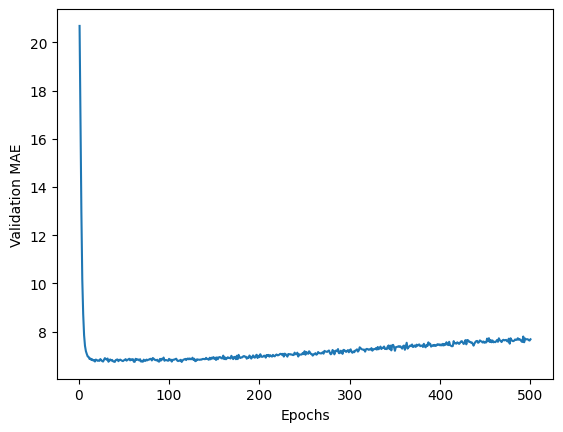

In [31]:
import matplotlib.pyplot as plt 
plt.plot(range(1,len(successive_avg_mae_score) + 1), successive_avg_mae_score)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

For the first few epochs is dramatically higher than the values that follow. Omitting first 10 points which are on different scale than the rest of the curve.

## Plotting again excluding first 10 data points 

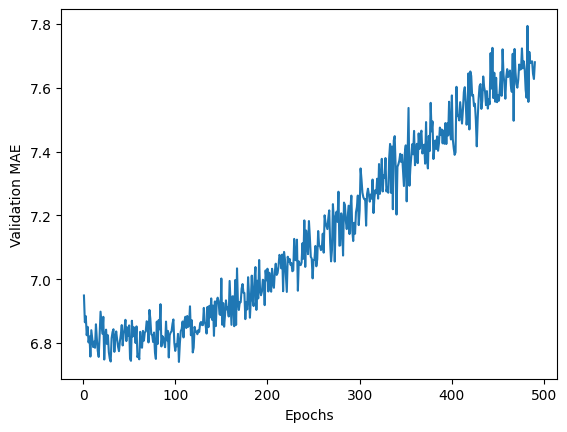

In [32]:
excluding_first_10 = successive_avg_mae_score[10:]
plt.plot(range(1,len(excluding_first_10) + 1), excluding_first_10)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

As can be observed from above graph that after about 90-100 epochs including the ones omited the MAE starts to incerease.
After taht point overfitting starts, so now we know where to stop learning. 

## Training the final model and evaluating on test data:

In [33]:
model = build_model()
model.fit(train_data,train_labels, #entire data
         epochs=120,
         batch_size=16,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data,test_labels)
print(test_mae_score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.3532 - mae: 2.2703 
2.5088813304901123


## Generating predictions on the test data:

In [34]:
predictions = model.predict(test_data)
print(predictions[0]) #predicted label
print(test_labels[0]) #expected label

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[8.609426]
7.2


## Key Takeaways:
* In regression problems mean squared error(MSE) is commonly used as a loss function.
* The concept of accuracy doesnt apply to regression problems so mean absolute error(MAE) is used for evaluation.
* Where the features are in different ranges we use normalization to scale them.
* When data is limited usage of K-folds validation is a great way to reliabaly evaluate the model.